### 实验3 卷积神经网络实验_二维卷积实验

In [1]:
import gc
import torch
from torch import nn
import torch.utils.data as Data
import torch.nn.functional as F
import pandas as pd
import numpy as np
from collections import OrderedDict
from pathlib import Path
from matplotlib import pyplot as plt
from PIL import Image
from typing import Tuple, Union


def train_epoch(data_loader: Data.DataLoader, net: nn.Module,
                loss_func, optimizer: torch.optim.Optimizer,
                device='cpu'):
    """
    训练迭代一次
    :param data_loader: 生成器 (x, y)
    :param net:         模型
    :param loss_func:   损失函数
    :param optimizer:   优化器
    :param device:      设备
    :return:    loss, acc
    """
    net.train()
    train_batch_num = len(data_loader)

    # 一次迭代中的 Loss、正确样本数、总样本数
    total_loss, correct, sample_num = 0, 0, 0

    for batch_num, (x, y_true) in enumerate(data_loader):

        # 将数据放入指定的设备
        x = x.to(device).float()
        y_true = y_true.to(device).long()

        # 计算损失
        y_hat: torch.Tensor = net(x)
        loss = loss_func(y_hat, y_true)

        # 取概率最大的类别索引
        y_true: torch.Tensor = y_true.view(-1)
        y_hat = y_hat.argmax(dim=1)

        # 反向传播
        optimizer.zero_grad() #清空梯度
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (y_true == y_hat).float().sum().item()
        sample_num += len(y_true)

    loss = total_loss / train_batch_num
    acc = correct / sample_num

    return loss, acc


def test_epoch(data_loader: Data.DataLoader,
               net: nn.Module, loss_func, device='cpu'):
    """
    测试函数迭代一次
    :param data_loader: 生成器 (x, y)
    :param net:         模型
    :param loss_func:   损失函数
    :param device:      设备
    :return:    loss, acc
    """
    net.eval()
    train_batch_num = len(data_loader)

    # 一次迭代中的 Loss、正确样本数、总样本数
    total_loss, correct, sample_num = 0, 0, 0

    with torch.no_grad():

        for batch_num, (x, y_true) in enumerate(data_loader):

            # 将数据放入指定的设备
            x = x.to(device).float()
            y_true = y_true.to(device).long()

            # 计算损失
            y_hat: torch.Tensor = net(x)
            loss = loss_func(y_hat, y_true)

            # 取概率最大的类别索引
            y_true: torch.Tensor = y_true.view(-1)
            y_hat = y_hat.argmax(dim=1)

            total_loss += loss.item()
            correct += (y_true == y_hat).float().sum().item()
            sample_num += len(y_true)

    loss = total_loss / train_batch_num
    acc = correct / sample_num

    return loss, acc


def plot_loss_accuracy(train_loss_list, train_acc_list,
                       test_loss_list, test_acc_list, info=''):
    """
    绘制 训练集和测试集正确率、损失值 的图形
    """
    x = np.linspace(0, len(train_loss_list), len(train_loss_list))
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(10, 6)
    if info:
        info = info + ' '

    ax1.plot(x, train_loss_list, 'b-', label="train_loss", lw=1)
    ax1.plot(x, test_loss_list, 'r-', label="test_loss", lw=1)
    ax1.set_title(info + 'Loss')
    ax1.legend(loc='best', frameon=False)
    ax1.set_xlabel("epoch")
    ax1.set_ylabel("Loss")

    ax2.plot(x, train_acc_list, 'b-', label="train_accuracy", lw=1)
    ax2.plot(x, test_acc_list, 'r-', label="test_accuracy", lw=1)
    ax2.set_title(info + 'Accuracy')
    ax2.legend(loc='best', frameon=False)
    ax2.set_xlabel("epoch")
    ax2.set_ylabel("Accuracy")

    plt.show()


def plot_by_dict(metrics: dict, shape: Tuple[int, int]):
    """
    绘制图形 {指标: {参数值名1: [], 参数值名2: []}}
    """
    fig, axes = plt.subplots(shape[0], shape[1])
    axes = list(np.array(axes).ravel())
    fig.set_size_inches(10*shape[0], 6*shape[1])

    colors = ['b', 'r', 'y', 'c', 'k', 'g', 'w', 'm']
    for ax_no, title in enumerate(metrics.keys()):
        ax = axes[ax_no]
        for i, (key, values) in enumerate(metrics.get(title, {}).items()):
            x = np.linspace(0, len(values), len(values))
            ax.plot(x, values, colors[i], label=key, lw=1)
            ax.set_title(title)
            ax.legend(loc='best', frameon=False)
            ax.set_xlabel("epoch")
            ax.set_ylabel(title.lower().split(' ')[-1])

    plt.show()

#### 卷积运算

In [2]:
def corr2d(X: torch.Tensor, K: torch.Tensor):
    """
    二维卷积运算
    :param X:   输入， shape：(batch_size, H,W)
    :param K:   卷积核，shape：(K_H, K_W)
    :return:  shape [H-K_H+1, W-K_w+1]
    """
    batch_size, h, w = X.shape
    k_h, k_w = K.shape[-2], K.shape[-1]

    # 初始化结果矩阵
    Y = torch.zeros(batch_size, h - k_h + 1, w - k_w + 1)
    for i in range(Y.shape[-2]):
        for j in range(Y.shape[-1]):
            Y[:, i, j] = (X[:, i: i+k_h, j: j+k_w] * K).sum()
    return Y


def corr2d_multi_in(X: torch.Tensor, K: torch.Tensor):
    """
    二维卷积运算 多输入通道
    遍历每个通道做卷积运算，再将不同通道的值相加。卷积核通道数 = 输入通道数
    :param X:   输入， shape：(batch_size, C_in, H, W)
    :param K:   卷积核，shape：(C_in, K_H, K_W)
    :return:  shape [H-K_H+1, W-K_w+1]
    """
    res = corr2d(X[:, 0, :, :], K[0, :, :])

    # 按通道相加
    for i in range(1, X.shape[1]):
        res += corr2d(X[:,i, :, :], K[i, :, :])
    return res


def corr2d_multi_in_out(X: torch.Tensor, K: torch.Tensor):
    """
    二维卷积运算 多输出通道
    输出通道数 = 卷积核个数
    :param X:   输入， shape：(batch_size, C_in, H,W)
    :param K:   卷积核，shape：(C_out, C_in, K_H, K_W)
    :return:  shape：[batch_size, C_out, H-K_H+1, W-K_w+1]
    """
    # 对 K 的第 0 维遍历，每次同输入 X 做互相关计算。
    return torch.stack([corr2d_multi_in(X, k) for k in K], dim=1)


def pool2d(X: torch.Tensor, pool_size: Tuple[int, int], mode='max'):
    """
    最大池化、平均池化
    :param X:           [h, w]
    :param pool_size:   [p_h, p_w]
    :param mode:        max、avg
    :return:            [h-p_h+1, w-p_w+1]
    """
    X = X.float()
    h, w = X.shape[0], X.shape[1]
    p_h, p_w = pool_size
    mode = mode.lower()

    Y = torch.zeros(h - p_h + 1, w - p_w + 1)
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i, j] = X[i: i+p_h, j: j+p_w].max()
            elif mode == 'avg':
                Y[i, j] = X[i: i+p_h, j: j+p_w].mean()
    return Y

In [3]:
# 二维卷积运算
X = torch.tensor([[[0, 1, 2], [3, 4, 5], [6, 7, 8]]])
K = torch.tensor([[0, 1], [2, 3]])
corr2d(X, K)

tensor([[[19., 25.],
         [37., 43.]]])

In [4]:
# 二维卷积运算(多输入通道)
X = torch.tensor([[[[0, 1, 2], [3, 4, 5], [6, 7, 8]],
                  [[1, 2, 3], [4, 5, 6], [7, 8, 9]]]])
K = torch.tensor([[[0, 1], [2, 3]],
                  [[1, 2], [3, 4]]])
corr2d_multi_in(X, K)

tensor([[[ 56.,  72.],
         [104., 120.]]])

In [5]:
# 二维卷积运算(多输出通道)
X = torch.arange(192, dtype=torch.float).view((1, 3, 8, 8))
K = torch.arange(108, dtype=torch.float).view((4, 3, 3, 3))
Y = corr2d_multi_in_out(X, K)
print(f'X.shape = {X.shape}\nK.shape = {K.shape}\nY.shape = {Y.shape}')

X.shape = torch.Size([1, 3, 8, 8])
K.shape = torch.Size([4, 3, 3, 3])
Y.shape = torch.Size([1, 4, 6, 6])


In [6]:
# 池化
X = torch.tensor([[0, 1, 2], [3, 4, 5], [6, 7, 8]])
print('最大池化:\n', pool2d(X, (2, 2), mode='max'))
print('平均池化:\n', pool2d(X, (2, 2), mode='avg'))


最大池化:
 tensor([[4., 5.],
        [7., 8.]])
平均池化:
 tensor([[2., 3.],
        [5., 6.]])


#### 数据集介绍 
分类任务：数据集——车辆分类数据<br>
+ 输入图片，输出对应的类别
+ 共1358张车辆图片
+ 分别属于汽车、客车和货车三类
+ 汽车：779张、客车：218张、 货车：360张
+ 每个类别的后20-30%当作测试集
+ 各图片的大小不一，需要将图片拉伸到相同大小

In [7]:
# data_dir = Path('/Users/zhengchubin/PycharmProjects/learn/data/实验4_check-in轨迹数据/')
data_dir = Path('/root/zhengchubin/data/实验3_数据集/车辆分类数据集')

test_size = 0.25
train_x, train_y, test_x, test_y = [], [], [], []
label2index, index2label = {}, {}
for i, directory in enumerate(data_dir.iterdir()):

    # 读取标签
    label2index[directory.name] = i
    index2label[i] = directory.name

    end_of_train = len([_ for _ in directory.rglob('*.jpg')]) * (1 - test_size)

    for num, file in enumerate(directory.rglob('*.jpg'), start=1):
        img = Image.open(file)
        img = img.resize((120, 100), Image.ANTIALIAS)

        # [H, W, C] = [100, 120, 3]
        img = np.array(img)

        # 转换为 [C, H, W] = [3, 100, 120]
        img = img.transpose(2, 0, 1)

        # 归一化
        img = img / 255

        if num <= end_of_train:
            train_x.append(torch.from_numpy(img))
            train_y.append(i)
        else:
            test_x.append(torch.from_numpy(img))
            test_y.append(i)

train_x, train_y = torch.stack(train_x), torch.Tensor(train_y)
test_x, test_y = torch.stack(test_x), torch.Tensor(test_y)

print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)
print('label2index:', label2index)

train_set = torch.utils.data.TensorDataset(train_x, train_y)
test_set = torch.utils.data.TensorDataset(test_x, test_y)

torch.Size([1017, 3, 100, 120]) torch.Size([1017])
torch.Size([340, 3, 100, 120]) torch.Size([340])
label2index: {'bus': 0, 'truck': 1, 'car': 2}


#### 手写二维卷积的实现

In [8]:
class MyConv2D(nn.Module):

    def __init__(self, in_channels: int, out_channels: int,
                 kernel_size: Union[Tuple[int, int], int]):
        super(MyConv2D, self).__init__()

        if isinstance(kernel_size, int):
            kernel_size = (kernel_size, kernel_size)

        # 卷积核 [C_out, C_in, K_h, K_w]
        self.weight = nn.Parameter(torch.randn((out_channels, in_channels)+kernel_size))

        # 偏差
        self.bias = nn.Parameter(torch.randn((out_channels, 1, 1)))

    def forward(self, x):
        """
        输入图片
        :param x:   [batch_size, C_in, H, W]
        :return: [batch_size, C_out, H-K_H+1, W-K_w+1]
        """
        return corr2d_multi_in_out(x, self.weight) + self.bias


class MyConvModule(nn.Module):

    def __init__(self, in_channels:int, out_channels: int,
                 kernel_size: Union[Tuple[int, int], int], output_size: int):
        super(MyConvModule, self).__init__()

        # 定义卷积层
        self.conv = nn.Sequential(
            MyConv2D(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

        # 输出层
        self.fc = nn.Linear(out_channels, output_size)

    def forward(self, x):
        """
        输入图片
        :param x:   [batch_size, C_in, H, W]
        :return:
        """
        # 3层卷积 => [batch_size, C_out, H, W]
        output = self.conv(x)

        # 平均池化 => [batch_size, C_out, 1, 1]
        output: torch.Tensor = F.avg_pool2d(output, kernel_size=(output.shape[-2], output.shape[-1]))

        # 压缩 => [batch_size, C_out]
        output = output.squeeze()

        # 全连接 => [batch_size, num_classes]
        output = self.fc(output)

        return output

MyConvModule(
  (conv): Sequential(
    (0): MyConv2D()
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (fc): Linear(in_features=8, out_features=3, bias=True)
)
epoch 1, train_loss 0.989450, test_loss 1.013148, train_acc 0.574238, test_acc 0.574238
epoch 2, train_loss 0.966686, test_loss 1.073384, train_acc 0.574238, test_acc 0.574238
epoch 3, train_loss 0.968735, test_loss 0.972517, train_acc 0.574238, test_acc 0.574238
epoch 4, train_loss 0.966079, test_loss 0.966989, train_acc 0.574238, test_acc 0.574238
epoch 5, train_loss 0.964448, test_loss 1.228947, train_acc 0.574238, test_acc 0.574238


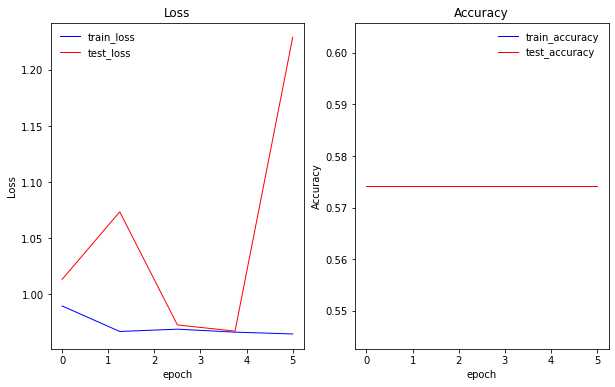

In [9]:
batch_size = 64
output_size = len(label2index)
num_epochs = 5
lr = 0.01
device = 'cpu'

net = MyConvModule(in_channels=3, out_channels=8,
                   kernel_size=(3, 3), output_size=output_size).to(device)
print(net)
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

for epoch in range(num_epochs):
    train_data_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_data_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

    train_loss, train_acc = train_epoch(data_loader=train_data_loader, net=net,
                                        loss_func=loss_func, optimizer=optimizer, device=device)
    test_loss, test_acc = test_epoch(data_loader=train_data_loader, net=net,
                                     loss_func=loss_func, device=device)

    print('epoch %d, train_loss %f, test_loss %f, train_acc %f, test_acc %f'
          % (epoch+1, train_loss, test_loss, train_acc, test_acc))

    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)

plot_loss_accuracy(train_loss_list, train_acc_list, test_loss_list, test_acc_list)

#### torch.nn实现二维卷积

In [ ]:
class ConvModule(nn.Module):

    def __init__(self, in_channels:int, out_channels: int,
                 kernel_size: Union[Tuple[int, int], int], output_size: int):
        super(ConvModule, self).__init__()

        # 定义卷积层
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

        # 输出层
        self.fc = nn.Linear(out_channels, output_size)

    def forward(self, x):
        """
        输入图片
        :param x:   [batch_size, C_in, H, W]
        :return:
        """
        # 3层卷积 => [batch_size, C_out, H, W]
        output = self.conv(x)

        # 平均池化 => [batch_size, C_out, 1, 1]
        output: torch.Tensor = F.avg_pool2d(output, kernel_size=(output.shape[-2], output.shape[-1]))

        # 压缩 => [batch_size, C_out]
        output = output.squeeze()

        # 全连接 => [batch_size, num_classes]
        output = self.fc(output)

        return output

ConvModule(
  (conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (fc): Linear(in_features=16, out_features=3, bias=True)
)
epoch 1, train_loss 1.176877, test_loss 1.133709, train_acc 0.289086, test_acc 0.263520
epoch 2, train_loss 1.074517, test_loss 1.071173, train_acc 0.508358, test_acc 0.580138
epoch 3, train_loss 1.003672, test_loss 1.021584, train_acc 0.686332, test_acc 0.708948
epoch 4, train_loss 0.942799, test_loss 0.957874, train_acc 0.713864, test_acc 0.680433
epoch 5, train_loss 0.904012, test_loss 0.907141, train_acc 0.653884, test_acc 0.676500
epoch 6, train_loss 0.874372, test_loss 0.862281, train_acc 0.653884, test_acc 0.646018
epoch 7, train_loss 0.853031, test_loss 0.871648, train_acc 0.653884, test_acc 0.676500
epoch 8, train_loss 0.834772, test_loss 0.834081, train_acc 0.659784, test_acc 0.688299
epoch 9, train_loss 0.8

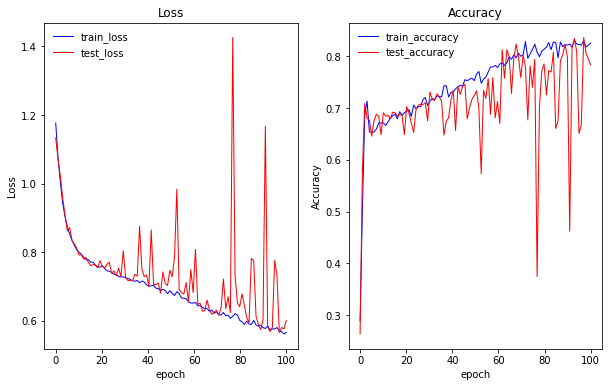

In [37]:
batch_size = 64
output_size = len(label2index)
num_epochs = 100
lr = 0.001
device = 'cpu'

net = ConvModule(in_channels=3, out_channels=16,
                 kernel_size=(3, 3), output_size=output_size).to(device)
print(net)
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

for epoch in range(num_epochs):
    train_data_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_data_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

    train_loss, train_acc = train_epoch(data_loader=train_data_loader, net=net,
                                        loss_func=loss_func, optimizer=optimizer, device=device)
    test_loss, test_acc = test_epoch(data_loader=test_data_loader, net=net,
                                     loss_func=loss_func, device=device)

    print('epoch %d, train_loss %f, test_loss %f, train_acc %f, test_acc %f'
          % (epoch+1, train_loss, test_loss, train_acc, test_acc))

    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)

plot_loss_accuracy(train_loss_list, train_acc_list, test_loss_list, test_acc_list)

不同超参数的对比分析

ConvModule(
  (conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (fc): Linear(in_features=16, out_features=3, bias=True)
)
lr=1.0 epoch 1, train_loss 1.509044, test_loss 3.248822, train_acc 0.521141, test_acc 0.251721
lr=1.0 epoch 2, train_loss 0.953747, test_loss 1.027045, train_acc 0.580138, test_acc 0.583088
lr=1.0 epoch 3, train_loss 0.895442, test_loss 0.916503, train_acc 0.595870, test_acc 0.617502
lr=1.0 epoch 4, train_loss 0.907452, test_loss 0.849896, train_acc 0.634218, test_acc 0.610619
lr=1.0 epoch 5, train_loss 0.871618, test_loss 0.849290, train_acc 0.613569, test_acc 0.736480
lr=1.0 epoch 6, train_loss 0.872263, test_loss 0.849980, train_acc 0.599803, test_acc 0.596853
lr=1.0 epoch 7, train_loss 0.873537, test_loss 0.879492, train_acc 0.646018, test_acc 0.632252
lr=1.0 epoch 8, train_loss 0.861699, test_loss 0.858668, train

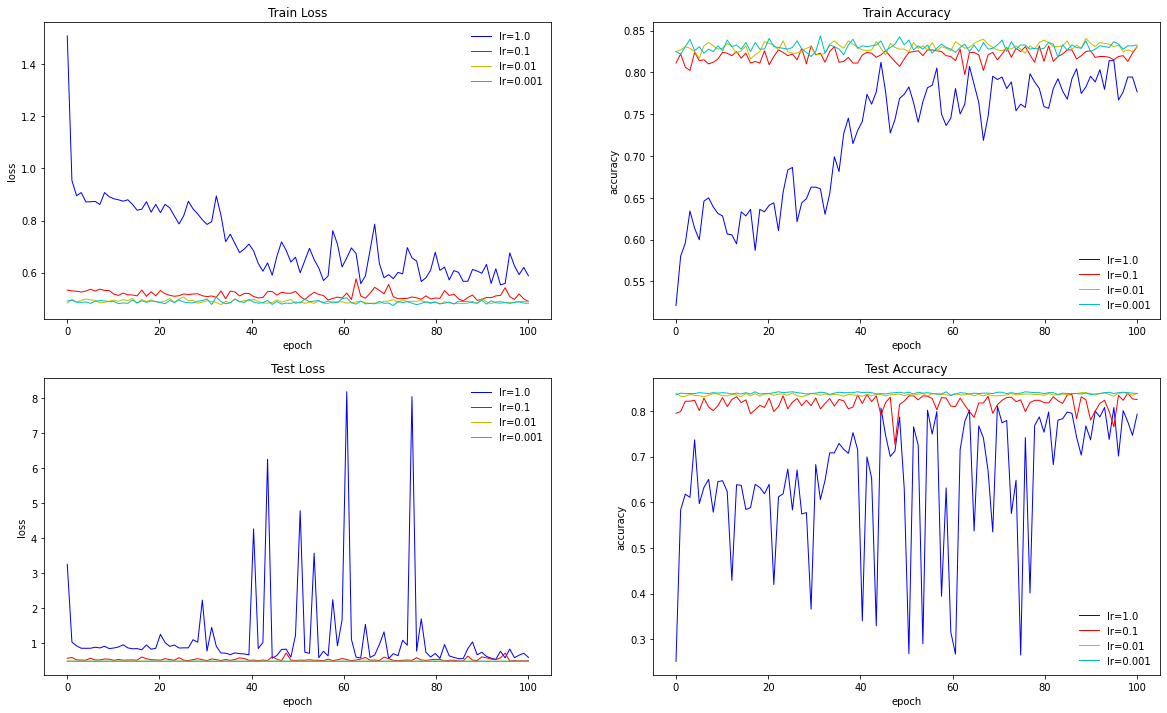

In [38]:
batch_size = 64
output_size = len(label2index)
num_epochs = 100
# lr = 0.001
device = 'cpu'

net = ConvModule(in_channels=3, out_channels=16,
                 kernel_size=(3, 3), output_size=output_size).to(device)
print(net)
loss_func = torch.nn.CrossEntropyLoss()

metric_dic = {
    'Train Loss': {},
    'Train Accuracy': {},
    'Test Loss': {},
    'Test Accuracy': {},
}

for lr in [1.0, 0.1, 0.01, 0.001]:

    train_loss_list = []
    train_acc_list = []
    test_loss_list = []
    test_acc_list = []

    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(num_epochs):
        train_data_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
        test_data_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

        train_loss, train_acc = train_epoch(data_loader=train_data_loader, net=net,
                                            loss_func=loss_func, optimizer=optimizer, device=device)
        test_loss, test_acc = test_epoch(data_loader=test_data_loader, net=net,
                                         loss_func=loss_func, device=device)

        print('lr=%s epoch %d, train_loss %f, test_loss %f, train_acc %f, test_acc %f'
              % (lr, epoch+1, train_loss, test_loss, train_acc, test_acc))

        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        test_loss_list.append(test_loss)
        test_acc_list.append(test_acc)

    metric_dic['Train Loss'][f'lr={lr}'] = train_loss_list
    metric_dic['Train Accuracy'][f'lr={lr}'] = train_acc_list
    metric_dic['Test Loss'][f'lr={lr}'] = test_loss_list
    metric_dic['Test Accuracy'][f'lr={lr}'] = test_acc_list

plot_by_dict(metric_dic, shape=(2, 2))
